# SurvivalStan

Tutorial: http://www.hammerlab.org/2017/06/26/introducing-survivalstan/

TODO

- [ ] Simulate Exponential model with covariates: 1 + age + sex the correct form?
- [ ] Try to reduce divergeces
- [ ] Why do coefficients not match?

## Set up environment

In [2]:
# Install Stan utilities

!rm stan_utility.py
!wget https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
    

# Upgrade pip
!pip3 install --user --upgrade pip


# Install PyStan
!pip3 install --user pystan


# Install SurvivalStan
!git clone https://github.com/hammerlab/survivalstan.git
!pip3 uninstall --yes survivalstan
!pip3 install --user survivalstan/.

--2019-07-24 11:37:33--  https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘stan_utility.py’

stan_utility.py     100%[===================>]   5.46K  --.-KB/s    in 0s      

2019-07-24 11:37:33 (113 MB/s) - ‘stan_utility.py’ saved [5593/5593]

Requirement already up-to-date: pip in /home/arnoldp9/.local/lib/python3.6/site-packages (19.2.1)
fatal: destination path 'survivalstan' already exists and is not an empty directory.
Uninstalling survivalstan-0.1.2.8:
  Successfully uninstalled survivalstan-0.1.2.8
Processing ./survivalstan


  Created wheel for survivalstan: filename=survivalstan-0.1.2.8-py2.py3-none-any.whl size=51505 sha256=9003c080b6876fb45d7f47c381dedab5cde90eab096c0fc59f1f10b87330aeeb
  Stored in directory: /tmp/pip-ephem-wheel-cache-cofecjdk/wheels/33/b7/50/b6af19b9184ab2e0a282506d84f8d2102acb5c0a23c0e611a6
Successfully built survivalstan


In [3]:
import sys
import os

import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

import pystan
import survivalstan

## Simple exponential model with covariates

This serves as a simple sanity check.

$S(t) = \exp( -at ) \exp( \beta \cdot X )$

The following prior strategy will be used:

* Priors for established risk factors
* Priors for factor with more uncertain relevance

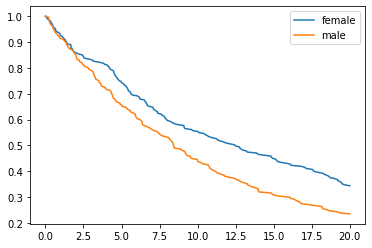

In [5]:
# Simulate Data
Nsim = 200

df2 = survivalstan.sim.sim_data_exp_correlated(
    N=500, censor_time=20, rate_form='1 + sex', rate_coefs=[-3, 0.5])


survivalstan.utils.plot_observed_survival(
    df2.query('sex == "female"'),
    time_col='t',
    event_col='event',
    label='female')

survivalstan.utils.plot_observed_survival(
    df2.query('sex == "male"'),
    time_col='t',
    event_col='event',
    label='male')

plt.legend()

In [6]:
# Infer parameters

ctrl = dict(adapt_delta = 0.9,
            max_treedepth = 20)

fit2_org = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex',
    model_cohort = 'exp model',
    iter = 2000,
    chains = 2,
    warmup = 1500,
    control = ctrl)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0176fed484efbd961d78e8973c25ff98 NOW.


NOT reusing model.


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Ran in 149.847 sec.


In [8]:
# Results
survivalstan.utils.filter_stan_summary([fit2_org], pars=['lp__','beta'])

sfit2_org = fit2_org['fit']
sfit2_org


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_0176fed484efbd961d78e8973c25ff98.
2 chains, each with iter=2000; warmup=1500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_s_raw     0.45    0.07   0.58 4.0e-3   0.08   0.23   0.58   1.97     76   1.02
tau_raw[1]  177.87   92.37 1745.9   0.22   0.96   2.67   9.58 752.67    357    1.0
tau_raw[2]    3.17     0.8  13.89   0.14   0.37   0.81   1.95  17.54    305   1.01
beta_raw[1]   0.72    0.04   0.62  -0.14   0.27   0.59   1.09   2.22    249   1.02
beta_raw[2]-5.1e-3    0.02   0.18  -0.44  -0.03-5.2e-4   0.02   0.38    135   1.01
alpha         0.06  1.3e-3   0.03   0.03   0.05   0.06   0.08   0.14    430    1.0
beta[1]       0.26  8.2e-3   0.12-2.5e-3   0.18   0.27   0.34   0.49    225   1.01
beta[2]    -9.1e-4  3.3e-4 6.9e-3  -0.02-5.5e-3-3.6e-4 3.8e-3   0.01    441    1.0
lp[1]         1.02    0.0

In [ ]:
# Plot divergent transitions
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility.partition_div(sfit2_org)

plot.scatter([x[0] for x in nondiv_params['theta']], nondiv_params['tau'], \
             color = mid_highlight, alpha=0.05)
plot.scatter([x[0] for x in div_params['theta']], div_params['tau'], \
             color = green, alpha=0.5)

plot.gca().set_xlabel("theta_1")
plot.gca().set_ylabel("tau")

plot.show()

In [26]:
# HMC diagnostics

sfit2_org = fit2_org['fit']

pystan.check_hmc_diagnostics(sfit2_org)

print(sfit2_org)

Inference for Stan model: anon_model_0176fed484efbd961d78e8973c25ff98.
4 chains, each with iter=4000; warmup=3500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_s_raw          1.97    0.09   2.03   0.15   0.75   1.84   1.96   8.08    513   1.01
tau_raw[1]        32.65    9.84 382.64   0.25    1.0   3.88   5.12 107.67   1513    1.0
tau_raw[2]         2.41    0.36   7.56   0.14   0.41   0.92   1.28  15.79    441   1.01
beta_raw[1]        0.79    0.03   0.53    0.1   0.48   0.65   0.96   2.19    336   1.02
beta_raw[2]        0.01    0.03   0.06   -0.1-9.1e-3-2.6e-4   0.07   0.11      4   1.47
alpha              0.09    0.03   0.06   0.02   0.04   0.08   0.16   0.21      5   1.27
beta[1]            1.55    0.47   0.68   0.85    1.1   1.24   2.23   2.71      2   5.11
beta[2]            0.03    0.05   0.07  -0.03  -0.01-5.8e-4   0.08   0.19      2   5.11
lp[1]            408

## More flexible baseline hazards: Piecewise hazard

One of the more critical parameterizations to get right is that of the baseline hazard. The baseline hazard behaves like an intercept in a typical regression model. It describes the instantaneous hazard over time for the population in the absence of any covariate effects. Failure to get this right can lead to all sorts of pathologies whereby the excess variation in hazard not accounted for by your modeled baseline hazard will be absorbed into covariate effects, yielding invalid inferences and potentially misleading conclusions.

*Aside: This is not a concern when using a Cox PH model for example, because the coefficient values are estimated using Maximum Likelihood Estimation (MLE) on a partial likelihood which does not include the baseline hazard. In a Bayesian analysis, however, we have the challenge of estimating the hazard as well as the coefficient effects.*

Most of the time, we do not have a prior belief on the distribution of the baseline hazard. We usually do not care that much about what the features of the baseline hazard look like (although perhaps we should!). Instead, we are concerned with making sure our inferences about coefficient values are valid.

We thus want a baseline hazard that is sufficiently flexible to absorb any variation in the hazard over time which should not be attributed to covariate values. We also however want to minimize the risk of overfitting, so that our posterior predicted probabilities of survival are well calibrated. Many of the semi- or non-parametric approaches to modeling baseline hazards are very flexible with a penalty to impose the upper bound of complexity.

Piecewise-Exponential Model: https://data.princeton.edu/wws509/notes/c7s4